In [141]:
import pandas as pd
import numpy as np
from datetime import date, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import openpyxl
from openpyxl.styles import Border, Side, PatternFill, Font, GradientFill, Alignment
from openpyxl.drawing.image import Image
import win32com.client as win32
import os
from PIL import ImageGrab
import win32com.client

olApp = win32.Dispatch('Outlook.Application')
olNS = olApp.GetNameSpace('MAPI')

import sys
sys.path.append("C:\\Users\\KlimovaAnnaA\\Documents\\MyFiles\\Projects\\OCP")
from Defs import merge_SalesUnits
from Defs import merge_Mapping
from Defs import Period
from Defs import new_list
from Defs import export_from_RISKCUSTOM
from Defs import add_in_currency_column
from Defs import concat_columns
from Defs import export_from_WHWEEK

In [142]:
data = pd.read_excel('US_Nola_fertilizers_2010-2024 (1).xlsx')
data.head(2)

,ID,CODE,INDENTIFYING_ATTRIBUTE,PRODUCT_CATEGORY,PRODUCT_GROUP,PRODUCT_BRIEF_NAME,PRODUCT_NAME,REGION,COMMODITY_CODE_LOCATION,PRICE_SOURCE,INFO_SOURCE,INCOTERMS,QUOTATION,FORWARD_BY,PUBLICATION_DATE,PERIOD,UNIT,CURRENCY_1,NAME,VALUE1
0,19,AN US Nola,NaN,Fertilizer,Nitrogen Fertilizers,Ammonium Nitrate,AN,North America,US Nola,FWeek,CRU,FOB,A Spot Weekly,S,2010-09-02,2010-09-02,st,USD,average,260.0
1,19,AN US Nola,NaN,Fertilizer,Nitrogen Fertilizers,Ammonium Nitrate,AN,North America,US Nola,FWeek,CRU,FOB,A Spot Weekly,S,2010-09-09,2010-09-09,st,USD,average,260.0


In [143]:
# data_U_32 = data_work[(data_work.PRODUCT_NAME=='UAN-32')&(data_work.PUBLICATION_DATE<'2017-01-01')&(data_work.PUBLICATION_DATE>'2016-01-01')]
# g = sns.lineplot(data_U_32, x='PUBLICATION_DATE', y='VALUE1')
# g.figure.set_size_inches(10,6)
# data_U_32

In [144]:
# # product = 'UAN-32'
# product = 'AN'
# data_U_32_ex = data[(data.PRODUCT_NAME==product)&(data.PUBLICATION_DATE<'2017-01-01')&(data.PUBLICATION_DATE>'2016-01-01')]

# g = sns.lineplot(data_U_32_ex, x='PUBLICATION_DATE', y='VALUE1', hue='INFO_SOURCE')
# g.figure.set_size_inches(10,3)

# # data_U_32_ex[data_U_32_ex.INFO_SOURCE=='Fertecon']

In [145]:
data_query = data[data.INFO_SOURCE!='Fertecon']

data_work = data_query.pivot_table(index=['PRODUCT_NAME','PUBLICATION_DATE'], values = 'VALUE1', aggfunc='mean').reset_index()
df_list = []
for PRODUCT_NAME in data_work.PRODUCT_NAME.unique().tolist():
    df_dict_string = {}
    df_dict_string['PRODUCT_NAME'] = PRODUCT_NAME
    product_df = data_work[data_work.PRODUCT_NAME==PRODUCT_NAME]
    for window in [52, 156, 260, len(product_df)]:
        Vol = 0
        Vol = list(product_df.iloc[-window:,:].VALUE1.pct_change().rolling(window-1).std()*100)[-1]
        if window == 52:
            df_dict_string['Vol_1_year'] = Vol
        elif window == 156:
            df_dict_string['Vol_3_year'] = Vol
        elif window == 260:
            df_dict_string['Vol_5_year'] = Vol
        else:
            df_dict_string['Vol_all'] = Vol
    df_list.append(df_dict_string)


In [146]:
vol_df = pd.DataFrame(df_list)
vol_df

,PRODUCT_NAME,Vol_1_year,Vol_3_year,Vol_5_year,Vol_all
0,AN,3.279278,4.092267,4.079510,2.988927
1,DAP,2.774785,3.581881,3.262134,2.450714
2,MAP 12:52,3.239876,3.124955,2.927482,2.351360
3,MOP G,1.424156,4.851836,5.283202,4.829977
4,TSP,2.475705,3.040367,2.801265,2.757608
5,UAN-32,3.349948,4.494363,4.197615,3.375572
6,Urea G,5.148337,6.860327,5.864448,4.617040
7,Urea P,9.341296,6.769779,5.617136,4.991243


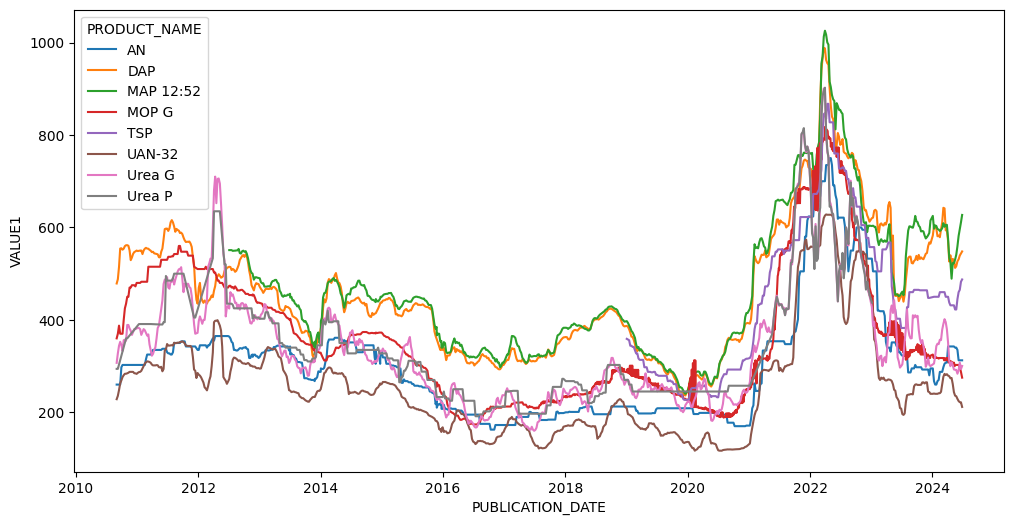

In [147]:
g = sns.lineplot(data_work, x='PUBLICATION_DATE', y='VALUE1',hue='PRODUCT_NAME')
g.figure.set_size_inches(12,6)
plt.savefig('Price.png')

In [148]:


Oui_file = f'{str(date.today())}_Price_volatility.xlsx'
writer = pd.ExcelWriter(Oui_file, engine='openpyxl')

vol_df.to_excel(writer, sheet_name='Price_Volatility')

worksheet = writer.sheets['Price_Volatility']
img = openpyxl.drawing.image.Image(f'Price.png')
img.anchor = 'H3'
worksheet.add_image(img)

data_query.to_excel(writer, sheet_name='data')

writer.close()
